# Prediction of Moz customer's monthly payment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
from sklearn.linear_model import Ridge

In [2]:
# load data
df_train = pd.read_csv('s3://mozbi-sr-data-science/data/moz_customer_data_train.csv', sep='|')
df_test = pd.read_csv('s3://mozbi-sr-data-science/data/moz_customer_data_test.csv', sep='|')

# 1 - EDA

Based on the training dataset of 48,000 customers, United States, Canada and United Kingdom consist of 78% of Moz's total customers from 8 countries across North America, Europe, and Asia. On average, the customers from these top 3 countries also pay most on monthy basis (Figure 1: Box plot of prior monthly paid by country) The customers from marketing industry are prominent with 37.7% followed by healthcare industry 24.9%, software industry 12.2% and the remaining allocated to unknown. 

On average, customers spent about 33 minutes last month, ranging from 10 minute (25 percentile) to 38 minutes (75 percentile). Interestingly, one software company from United Kingdom spent 837 minutes last month, which is 25 times longer than the average. While the time customers spent on Moz app showed the outliers, the monthly payment is consistent in the distribution without outliers, ranging from $64 (25 percentile), $88 (median), and $111 (75 percentile). Customers paid about 20 cent per second on average, and 6 cent per second on median. One marketing customer from United States paid $112.7 but spent only 1 second last month.

There exists an exponential relationship between monthly payment and time spenton the app through the scatter plot in every country (Figure 2: scatter plot between time spent and money paid in US). Interestingly, this relationship shows 3 different distinct groups, which is worth further research of the customer segmentation.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

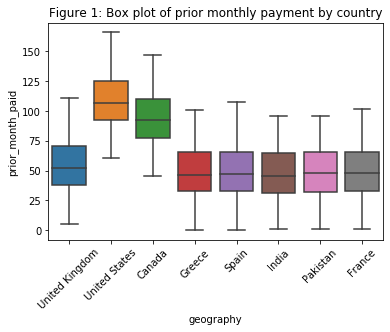

In [70]:
# box plot of prior monthly paid by country'
sns.boxplot(x = df_train['geography'],\
            y = df_train['prior_month_paid'], data = df_train,)\
            .set_title('Figure 1: Box plot of prior monthly payment by country')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Figure 2: Scatter plot between time spent and money paid in US')

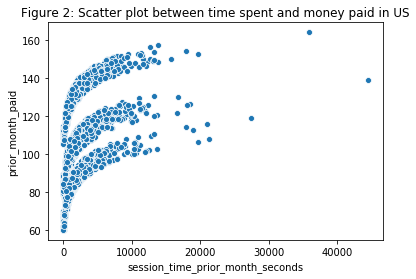

In [4]:
# scatter plot between time spent and money paid in US
sns.scatterplot(x = df_train[df_train['geography']=='United States']['session_time_prior_month_seconds']\
                , y = df_train[df_train['geography']=='United States']['prior_month_paid']\
                , data = df_train)\
                .set_title('Figure 2: Scatter plot between time spent and money paid in US')


In [5]:
df_train.head(3)

,id,industry,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid
0,1585597623,NaN,GB,Chrome,1092,25.607595
1,6531970533,healthcare,US,Firefox,2480,115.579494
2,8443866239,health care,Canada,Chrome,1671,89.462246


In [6]:
df_test.head(3)

,id,industry,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid
0,8721560330,health care,America,Safari,405,94.086123
1,5265684450,unk,England,IE,4460,44.434942
2,7023768415,Marketing Agency,Esp,Firefox,289,53.311472


## check null

In [7]:
df_train.isnull().sum()

id                                     0
industry                            7364
geography                              0
most_common_browser                    0
session_time_prior_month_seconds       0
prior_month_paid                       0
dtype: int64

In [8]:
df_train['industry'].value_counts()

marketing agency    6052
health care         6052
mktg agency         6031
Marketing Agency    6012
healthcare          5911
software            5879
unk                 2366
unknown             2333
Name: industry, dtype: int64

In [9]:
# fill na values of industry with unknown
df_train['industry'].fillna('unknown', inplace = True)

## standardize data

In [10]:
# standardize industry
def standardize_industry(name):
    if name == 'Marketing Agency' or name == 'mktg agency':
        return 'marketing agency'
    if name == 'health care':
        return 'healthcare'
    if name == 'unk':
        return 'unknown'
    else:
        return name
df_train['industry']  = df_train['industry'].apply(standardize_industry)
df_train['industry'].value_counts()

marketing agency    18095
unknown             12063
healthcare          11963
software             5879
Name: industry, dtype: int64

In [11]:
# standardize geography
df_train['geography'].value_counts()

USA               8573
CA                5381
Canada            5328
US                4309
America           4305
United States     4270
UK                2114
Pakistan          1797
Greece            1782
India             1773
Spain             1748
France            1739
Esp               1735
GB                1118
United Kingdom    1029
England            999
Name: geography, dtype: int64

In [12]:
def standardize_country_name(name):
    if name == 'CA':
        return 'Canada'
    elif name == 'US' or name == 'America' or name == 'USA':
        return 'United States'
    elif name == 'UK' or name == 'GB' or name == 'England':
        return 'United Kingdom'
    elif name == 'Esp':
        return 'Spain'
    else:
        return name
df_train['geography'] = df_train['geography'].apply(standardize_country_name)
df_train['geography'].value_counts()

United States     21457
Canada            10709
United Kingdom     5260
Spain              3483
Pakistan           1797
Greece             1782
India              1773
France             1739
Name: geography, dtype: int64

## visualize

### barchart of customers count by industry and geography

In [13]:
# industry
df_industry_count = df_train['industry'].value_counts()\
.rename_axis('industry')\
.reset_index(name = 'customer_count')

df_industry_count['customer_count_pct'] = df_industry_count['customer_count']/ df_industry_count['customer_count'].sum()
df_industry_count

,industry,customer_count,customer_count_pct
0,marketing agency,18095,0.376979
1,unknown,12063,0.251312
2,healthcare,11963,0.249229
3,software,5879,0.122479


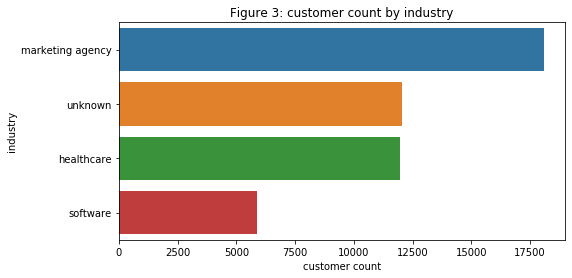

In [14]:
f, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x = df_industry_count['customer_count']\
            , y = df_industry_count['industry'])\
            .set(title='Figure 3: customer count by industry')
plt.xlabel("customer count")
plt.ylabel("industry")
plt.show()

In [15]:
# geography
df_geography_count = df_train['geography'].value_counts()\
.rename_axis('geography')\
.reset_index(name = 'customer_count')

df_geography_count['customer_count_pct'] = df_geography_count['customer_count']/ df_geography_count['customer_count'].sum()
df_geography_count

,geography,customer_count,customer_count_pct
0,United States,21457,0.447021
1,Canada,10709,0.223104
2,United Kingdom,5260,0.109583
3,Spain,3483,0.072563
4,Pakistan,1797,0.037437
5,Greece,1782,0.037125
6,India,1773,0.036937
7,France,1739,0.036229


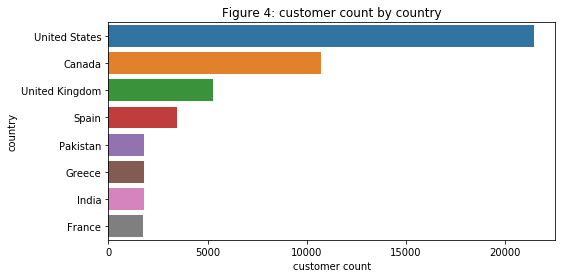

In [63]:
# geography
f, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x = df_geography_count['customer_count']\
            , y = df_geography_count['geography'])\
        .set(title='Figure 4: customer count by country')
plt.xlabel("customer count")
plt.ylabel("country")
plt.show()

In [17]:
# geography and industry
df_geography_industry_count = pd.DataFrame(df_train.groupby(by = ['geography', 'industry'], as_index = False).agg({'id': 'count'}))


df_geography_industry_count['customer_count_pct'] = df_geography_industry_count['id']/ df_geography_industry_count['id'].sum()
df_geography_industry_count = df_geography_industry_count.sort_values(by = ['geography', 'id', 'industry'], ascending = False)

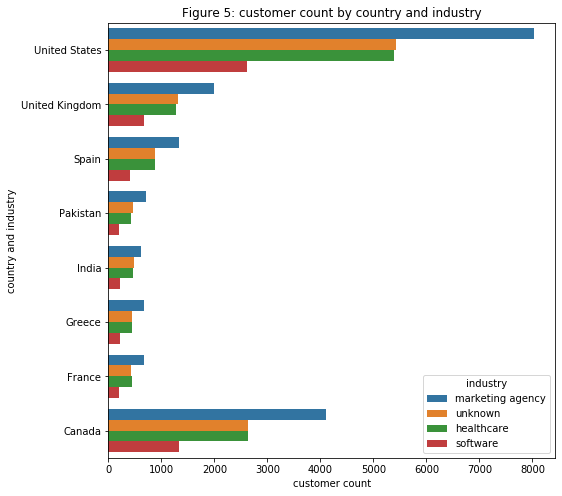

In [18]:
# geography and industry
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x = df_geography_industry_count['id'],\
            y = df_geography_industry_count['geography'],\
            hue = df_geography_industry_count['industry'])\
            .set(title='Figure 5: customer count by country and industry')
plt.xlabel("customer count")
plt.ylabel("country and industry")
plt.show()

### boxplot and histogram by session_time_prior_month_seconds,  prior_month_paid and paid_per_second

[Text(0.5, 1.0, 'Figure 6: Boxplot by session_time_prior_month_seconds')]

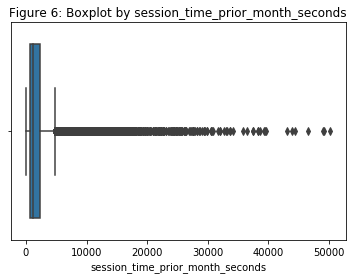

In [19]:
# boxplot by session_time_prior_month_seconds
sns.boxplot(df_train['session_time_prior_month_seconds'])\
    .set(title = 'Figure 6: Boxplot by session_time_prior_month_seconds')

In [20]:
df_train['session_time_prior_month_seconds'].describe()

count    48000.000000
mean      1952.151854
std       2579.835645
min          1.000000
25%        612.000000
50%       1210.000000
75%       2289.000000
max      50233.000000
Name: session_time_prior_month_seconds, dtype: float64

In [21]:
df_train[df_train['session_time_prior_month_seconds']==50233]

,id,industry,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid
23884,8823186432,software,United Kingdom,IE,50233,80.524291


[Text(0.5, 1.0, 'Figure 7: Boxplot of prior_month_paid')]

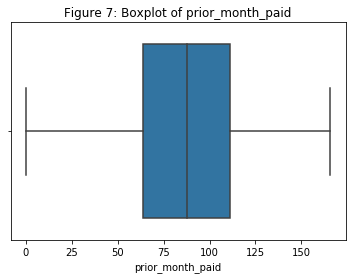

In [42]:
# boxplot of prior_month_paid
sns.boxplot(df_train['prior_month_paid'])\
    .set(title = 'Figure 7: Boxplot of prior_month_paid')

[Text(0.5, 1.0, 'Figure 8: Boxplot of prior_month_paid')]

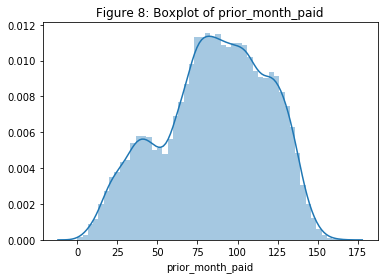

In [43]:
# histogram by prior_month_paid
sns.distplot(df_train['prior_month_paid'])\
    .set(title = 'Figure 8: Boxplot of prior_month_paid')

In [44]:
# paid_per_second
df_train['paid_per_second'] = df_train['prior_month_paid']/ df_train['session_time_prior_month_seconds']
df_train['paid_per_second'].describe()

count    48000.000000
mean         0.199307
std          1.377884
min          0.000404
25%          0.032754
50%          0.066212
75%          0.136171
max        112.700000
Name: paid_per_second, dtype: float64

In [25]:
df_train[df_train['paid_per_second']==112.7]

,id,industry,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid,paid_per_second
36699,1023888769,marketing agency,United States,Chrome,1,112.7,112.7


### scatter plot of between prior_month_paid and prior_month_seconds

[Text(0.5, 1.0, 'Figure 9: Scatter plot between time spent and money payment in Canada')]

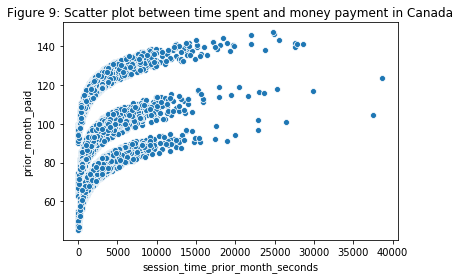

In [47]:
# scatter plot between time spent and money paid in Canada
sns.scatterplot(x = df_train[df_train['geography']=='Canada']['session_time_prior_month_seconds']\
                , y = df_train[df_train['geography']=='Canada']['prior_month_paid'], data = df_train)\
                .set(title = 'Figure 9: Scatter plot between time spent and money payment in Canada') 

[Text(0.5, 1.0, 'Figure 10: Scatter plot between time spent and money payment in United Kingdom')]

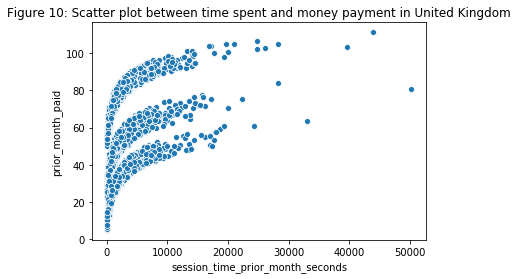

In [48]:
# scatter plot between time spent and money paid in United Kingdom
sns.scatterplot(x = df_train[df_train['geography']=='United Kingdom']['session_time_prior_month_seconds']\
                , y = df_train[df_train['geography']=='United Kingdom']['prior_month_paid'], data = df_train)\
                .set(title = 'Figure 10: Scatter plot between time spent and money payment in United Kingdom') 

### box plot of between prior_month_paid across geography, industry and browser

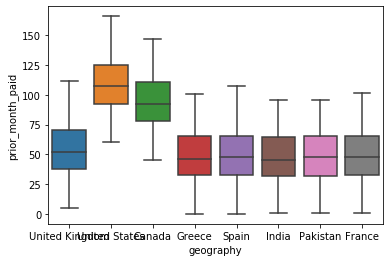

In [28]:
# geography
sns.boxplot(x = df_train['geography'],\
            y = df_train['prior_month_paid'], data = df_train)\
            .set(title = 'Figure 11: Boxplot of money payment across geography') 

[Text(0.5, 1.0, 'Figure 12: Boxplot of money payment across industry')]

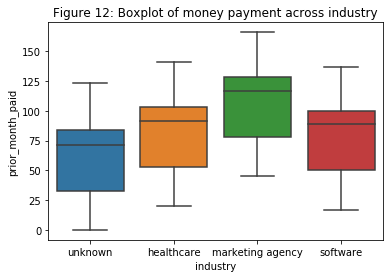

In [64]:
# industry
sns.boxplot(x = df_train['industry'],\
            y = df_train['prior_month_paid'], data = df_train)\
            .set(title = 'Figure 12: Boxplot of money payment across industry')  

[Text(0.5, 1.0, 'Figure 13: Boxplot of money payment across browser')]

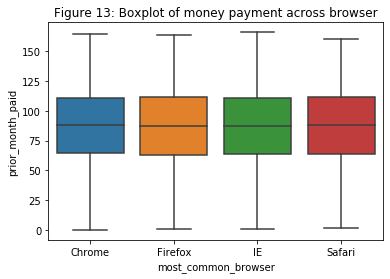

In [50]:
# browser
sns.boxplot(x = df_train['most_common_browser'],\
            y = df_train['prior_month_paid'], data = df_train)\
            .set(title = 'Figure 13: Boxplot of money payment across browser')  

[Text(0.5, 1.0, 'Figure 14: Boxplot of money payment per second across geography')]

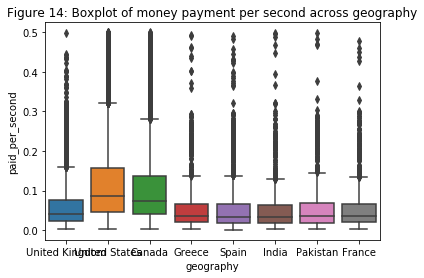

In [65]:
# paymnet per second across geography
sns.boxplot(x = df_train[df_train['paid_per_second']<1]['geography']\
            , y = df_train[df_train['paid_per_second']<0.5]['paid_per_second'],\
            data = df_train[df_train['paid_per_second']<1])\
            .set(title = 'Figure 14: Boxplot of money payment per second across geography')  

# 2 -  Linear regression model which estimates the prior_month_paid as a function of some (or all) of the attributes contained in the file. 

With the observation in the scatter plot that there exists an exponential relationship between time spent and monthly payment, the linear regression with exponential feature of time spent is implemented to predict monthly payment. Other explanatory variables including geography and industry are transformed into dummy variables. Since there is no difference in monthly payment among browsers, only time spent, geography dummy, and industry dummy are taken into account as explanatory variables to predict monthly payment.

To minimize the cost function, the difference between observed monthly payment and predicted monthly payment, as well as to select meaningful features in the linear regression, MSE and R-squared are 2 performance metrics to evaluate. Ridge regularization is also added to the cost function to dampen the overfitting modelling.

In [32]:
df_train_v2 = df_train.copy()

# get dummies for geography, industry and most_common_browser
df_train_v2 = pd.concat([df_train, pd.get_dummies(df_train['geography'])],axis=1)
df_train_v2.drop(['geography'],axis=1, inplace=True)

df_train_v2 = pd.concat([df_train_v2, pd.get_dummies(df_train['industry'])],axis=1)
df_train_v2.drop(['industry'],axis=1, inplace=True)

df_train_v2 = pd.concat([df_train_v2, pd.get_dummies(df_train['most_common_browser'])],axis=1)
df_train_v2.drop(['most_common_browser'],axis=1, inplace=True)

# log session_time_prior_month_seconds for linear regression with exponential pattern
df_train_v2['session_time_prior_month_seconds_log'] = np.log(df_train['session_time_prior_month_seconds'])

df_train_v2.columns

Index(['id', 'session_time_prior_month_seconds', 'prior_month_paid',
       'paid_per_second', 'Canada', 'France', 'Greece', 'India', 'Pakistan',
       'Spain', 'United Kingdom', 'United States', 'healthcare',
       'marketing agency', 'software', 'unknown', 'Chrome', 'Firefox', 'IE',
       'Safari', 'session_time_prior_month_seconds_log'],
      dtype='object')

In [33]:
df_train_v2.head(3)

,id,session_time_prior_month_seconds,prior_month_paid,paid_per_second,Canada,France,Greece,India,Pakistan,Spain,...,United States,healthcare,marketing agency,software,unknown,Chrome,Firefox,IE,Safari,session_time_prior_month_seconds_log
0,1585597623,1092,25.607595,0.023450,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,6.995766
1,6531970533,2480,115.579494,0.046605,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,7.816014
2,8443866239,1671,89.462246,0.053538,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,7.421178


In [34]:
# option 1: linear regression with log('session_time_prior_month_seconds')
# select features
X_columns1 = ['session_time_prior_month_seconds_log']
X_train1 = sm.add_constant(df_train_v2[X_columns1]).values
y_train = df_train_v2['prior_month_paid'].values.reshape(-1,1)
sm.add_constant
# linear regression
lr1 = sm.OLS(y_train, X_train1).fit()
y_train_predict_lr1 = lr1.predict(X_train1) 


print('MSE:', np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_predict_lr1)))
print('R^2:', sklearn.metrics.r2_score(y_train, y_train_predict_lr1))

# statistic summary
lr1.summary()

MSE: 31.575676889431307
R^2: 0.07067344455516633


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     3650.
Date:                Sat, 29 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:02:11   Log-Likelihood:            -2.3382e+05
No. Observations:               48000   AIC:                         4.677e+05
Df Residuals:                   47998   BIC:                         4.677e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.5973      0.889     36.649      0.000      30.854      34.341
x1             7.5675      0.125     60.416      0.000       7.322       7.813
==============================================================================
Omnibus:                     4898.955   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2121.274
Skew:                          -0.324   Prob(JB):                         0.00
Kurtosis:                       2.199   Cond. No.                         44.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# option 2: linear regression with log('session_time_prior_month_seconds'), geography dummies
# select features
X_columns2 = ['session_time_prior_month_seconds_log',\
            'United States', 'Canada', 'United Kingdom',\
            'France', 'Spain', 'Greece', 'India', 'Pakistan'
           ]
X_train2 =  sm.add_constant(df_train_v2[X_columns2]).values
y_train = df_train_v2['prior_month_paid'].values.reshape(-1,1)

# linear regression
lr2 = sm.OLS(y_train, X_train2).fit()
y_train_predict_lr2 = lr2.predict(X_train2) 

print('MSE:', np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_predict_lr2)))
print('R^2:', sklearn.metrics.r2_score(y_train, y_train_predict_lr2))

# statistic summary
lr2.summary()

MSE: 18.289292373121828
R^2: 0.6882138539018423


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                 1.324e+04
Date:                Sat, 29 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:10:32   Log-Likelihood:            -2.0761e+05
No. Observations:               48000   AIC:                         4.152e+05
Df Residuals:                   47991   BIC:                         4.153e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8484      0.465     16.876      0.000       6.937       8.760
x1             7.5766      0.073    104.418      0.000       7.434       7.719
x2            47.1233      0.165    285.831      0.000      46.800      47.446
x3            32.5795      0.198    164.306      0.000      32.191      32.968
x4            -7.5736      0.254    -29.847      0.000      -8.071      -7.076
x5           -12.6052      0.406    -31.046      0.000     -13.401     -11.809
x6           -12.4803      0.300    -41.628      0.000     -13.068     -11.893
x7           -12.9521      0.401    -32.279      0.000     -13.739     -12.166
x8           -13.9251      0.403    -34.581      0.000     -14.714     -13.136
x9           -12.3181      0.399    -30.834      0.000     -13.101     -11.535
==============================================================================
Omnibus:                   757329.376   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3684.015
Skew:                          -0.002   Prob(JB):                         0.00
Kurtosis:                       1.643   Cond. No.                     4.47e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.24e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [54]:
# option 3.1: linear regression with log('session_time_prior_month_seconds'), geography dummies and industry dummies
# select features
X_columns3 = ['session_time_prior_month_seconds_log',\
            'United States', 'Canada', 'United Kingdom',\
            'France', 'Spain', 'Greece', 'India', 'Pakistan',\
             'marketing agency', 'healthcare', 'software', 'unknown'
           ]
X_train3 = sm.add_constant(df_train_v2[X_columns3]).values
y_train = df_train_v2['prior_month_paid'].values.reshape(-1,1)

# linear regression
lr3 = sm.OLS(y_train, X_train3).fit()
y_train_predict_lr3 = lr3.predict(X_train3) 

print('MSE:', np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_predict_lr3)))
print('R^2:', sklearn.metrics.r2_score(y_train, y_train_predict_lr3))

# statistic summary
lr3.summary()

MSE: 3.5986114092845116
R^2: 0.9879292872867514


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 3.571e+05
Date:                Sat, 29 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:10:42   Log-Likelihood:            -1.2958e+05
No. Observations:               48000   AIC:                         2.592e+05
Df Residuals:                   47988   BIC:                         2.593e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6934      0.075     49.203      0.000       3.546       3.841
x1             7.6148      0.014    533.332      0.000       7.587       7.643
x2            46.6530      0.032   1453.660      0.000      46.590      46.716
x3            31.7150      0.039    819.622      0.000      31.639      31.791
x4            -8.2413      0.050   -166.093      0.000      -8.339      -8.144
x5           -13.3978      0.080   -168.457      0.000     -13.554     -13.242
x6           -13.1841      0.059   -224.739      0.000     -13.299     -13.069
x7           -13.4510      0.079   -171.132      0.000     -13.605     -13.297
x8           -13.1747      0.079   -167.046      0.000     -13.329     -13.020
x9           -13.2257      0.078   -168.972      0.000     -13.379     -13.072
x10           25.4727      0.031    816.011      0.000      25.411      25.534
x11            0.4168      0.034     12.083      0.000       0.349       0.484
x12           -2.6400      0.043    -61.149      0.000      -2.725      -2.555
x13          -19.5561      0.034   -567.387      0.000     -19.624     -19.489
==============================================================================
Omnibus:                    13925.358   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            95001.323
Skew:                           1.222   Prob(JB):                         0.00
Kurtosis:                       9.444   Cond. No.                     4.10e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.48e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [55]:
# option 3.2: linear regression with log('session_time_prior_month_seconds'), geography dummies and industry dummies with regularization
# select features
lr_r3 = Ridge(alpha=0.01)
lr_r3.fit(X_train3, y_train) 
y_train_predict_lr_r3 = lr_r3.predict(X_train3)

print('MSE:', np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_predict_lr_r3)))
print('R^2:', sklearn.metrics.r2_score(y_train, y_train_predict_lr_r3))

print('coeficient:', lr_r3.coef_)
print('intercept:', lr_r3.intercept_)

MSE: 3.5986114095034476
R^2: 0.9879292872852827
coeficient: [[  0.           7.61475486  46.19125513  31.25325345  -8.70301906
  -13.85941287 -13.64578928 -13.91265842 -13.63630421 -13.6873246
   24.54931707  -0.50658926  -3.56332226 -20.47940562]]
intercept: [5.07845506]


# 3 - Inferential interpretation of regression model.

By adding geography dummy to time spent feature in log, R-squared increases to 68.8% from 7.1%, and MSE improves to 18.2 from 31.6. Lastly, by adding industry dummy to time spent feature in log and geography dummy, R-squared reaches 98.8% and MSE reaches 3.6 with Ridge regularization (hyperparmeter = 0.01).

All the exlanatory features are statistically significant with p_values of almost 0 (to test each individual feature significance on the explained variable). F-statistic test is also statistically significant with 1320 (to test the overall significance of regression).

Regarding the impact of each explanatory variables on monthly payment, the first following 4 features are worth taken into account. 
1. 'session_time_prior_month_seconds_log' (or 'log(session_time_prior_month_seconds')): 7.61475486. 
For 1% increase in session_time_month_seconds, the difference in the average prior_month_paid will increase $ 7.61475486.log(1.01) = $ 0.076 (or 7.6 cent).

2. 'United States': 46.19125513
For customer from United State, Moz could earn more $46.2 compared to other countries.

3. 'Canada': 31.25325345
For customer from Canada, Moz could earn more $31.3 compared to other countries.

4. 'marketing agency': 24.54931706
For customer specializing in marketing, Moz could earn more $24.5 compared to other industries.


5. The following features show negative coefficients indicates Moz could earn less if the customers fall into the following countries and industries. 

'United Kingdom': -8.70301906; 'France': -13.85941287; 'Spain': -13.64578928; 'Greece': -13.91265842; 'India': -13.63630421; 'Pakistan': -13.6873246

'healthcare': -0.50658926; 'software': -3.56332226; 'unknown': -20.4794056


# 4 - Run model against the training data set, and describe its performance.

With the linear regression with the exponential feature session_time_prior_month_seconds and the geography and industry dummies, along with Ridge regularization, the test set reached higher MSE (4.47%) and lower R^2 (0.1%) compared to the train set. However, the model explained 98.7% of variability of the response data around its mean in the test set.
The following is the detailed comparison of model performance between training set and test set.

Traing set
MSE: 3.5986114095034476; R^2: 0.9879292872852827

Test set
MSE: 3.7596259857230514; R^2: 0.9869856132969931

In [56]:
df_test['industry'].fillna('unknown', inplace = True)
df_test['industry']  = df_test['industry'].apply(standardize_industry)
df_test['geography'] = df_test['geography'].apply(standardize_country_name)

In [59]:
df_test_v2 = df_test.copy()

# get dummies for geography, industry and most_common_browser
df_test_v2 = pd.concat([df_test, pd.get_dummies(df_test['geography'])],axis=1)
df_test_v2.drop(['geography'],axis=1, inplace=True)

df_test_v2 = pd.concat([df_test_v2, pd.get_dummies(df_test['industry'])],axis=1)
df_test_v2.drop(['industry'],axis=1, inplace=True)

df_test_v2 = pd.concat([df_test_v2, pd.get_dummies(df_test['most_common_browser'])],axis=1)
df_test_v2.drop(['most_common_browser'],axis=1, inplace=True)

# log session_time_prior_month_seconds for linear regression with exponential pattern
df_test_v2['session_time_prior_month_seconds_log'] = np.log(df_test['session_time_prior_month_seconds'])

In [62]:
# option 4 test: linear regression with log('session_time_prior_month_seconds'), geography dummies and industry dummies with regularization
X_columns3 = ['session_time_prior_month_seconds_log',\
            'United States', 'Canada', 'United Kingdom',\
            'France', 'Spain', 'Greece', 'India', 'Pakistan',\
             'marketing agency', 'healthcare', 'software', 'unknown'
           ]

X_test3 = sm.add_constant(df_test_v2[X_columns3]).values
y_test = df_test_v2['prior_month_paid'].values.reshape(-1,1)

y_test_predict_lr_r3 = lr_r3.predict(X_test3)
print('MSE:', np.sqrt(sklearn.metrics.mean_squared_error(y_test,y_test_predict_lr_r3))) 
print('R^2:', sklearn.metrics.r2_score(y_test, y_test_predict_lr_r3))

MSE: 3.7596259857230514
R^2: 0.9869856132969931


# 5- Recommendation for the next steps for the business

First, based on the positive impact of customers from North America and marketing industry on monthly payment, Moz could focus on North America customers including US and Canada specializing in the marketing industry for current customer retention programs and pontential customer attraction programs. 

Second, based on the exponetial relationship between time spent and monthly payment, Moz could implement some engagement incentives to increase the time customers spending on the Moz apps, which also helps increase customer loyalty, boosts monthly payment and ultimately increases Moz's revenue. 

Third, Moz could do additional research to have better understanding customer segmentation for pricing strategy and customized customer engagement programs since there are 3 interesting distinct groups from the obserevation between time spent and monthly payment.